# SingleCell Data Analysis on the CPU
**Author:** [Severin Dicks](https://github.com/Intron7) (IBSM Freiburg)

To run this notebook please make sure you have a working enviroment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of ca. 90000 cells from [Quin et al., Cell Research 2020](https://www.nature.com/articles/s41422-020-0355-0).

In [1]:
import numpy as np
import scanpy as sc
import anndata

import time


import matplotlib.pyplot as plt
from matplotlib import rcParams

sc.set_figure_params(dpi= 80, dpi_save = 300)
rcParams['figure.figsize'] = 5,5

sc._settings.ScanpyConfig.n_jobs = 60

## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. 

In [2]:
data_load_start = time.time()

In [3]:
%%time
adata=sc.read("h5/adata.raw.h5ad")

CPU times: user 2.55 s, sys: 96.2 ms, total: 2.65 s
Wall time: 2.65 s


In [4]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 2.6604533195495605


## Preprocessing

In [5]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

Some genes will now have zero expression in all cells. We filter out such genes.

In [6]:
%%time
adata.var['MT'] = adata.var_names.str.startswith('MT-') 

CPU times: user 7.83 ms, sys: 0 ns, total: 7.83 ms
Wall time: 7.58 ms


In [7]:
%%time
adata.var['RIBO'] = adata.var_names.str.startswith('RPS') 


CPU times: user 5.51 ms, sys: 0 ns, total: 5.51 ms
Wall time: 5.44 ms


In [8]:
%%time
sc.pp.calculate_qc_metrics(adata, qc_vars=['MT','RIBO'], percent_top=None, log1p=False, inplace=True)

CPU times: user 1.59 s, sys: 72.7 ms, total: 1.66 s
Wall time: 1.66 s


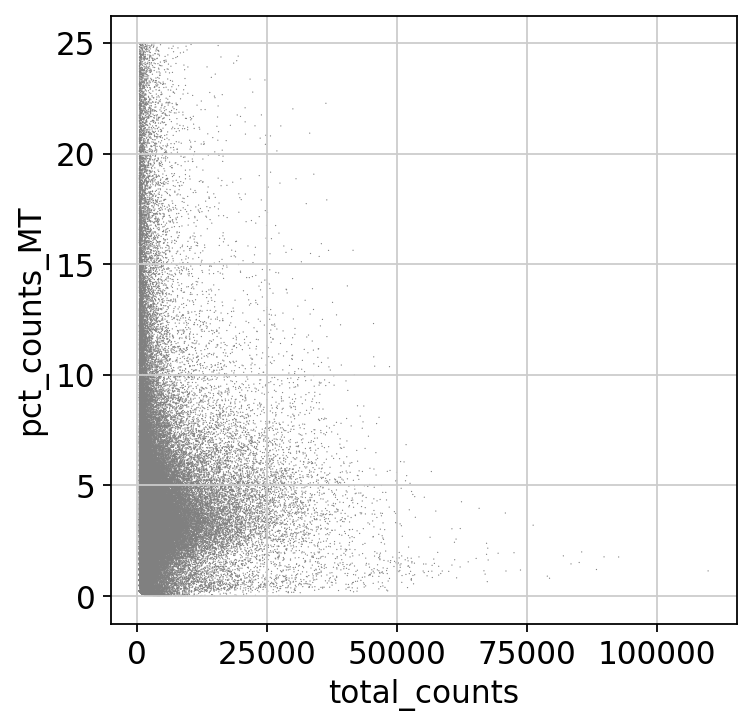

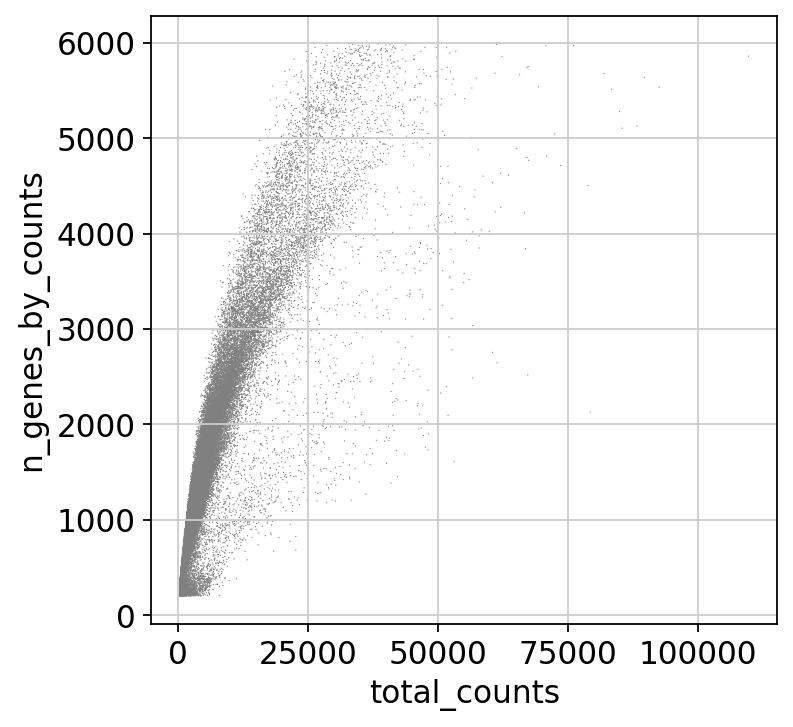

In [9]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_MT')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

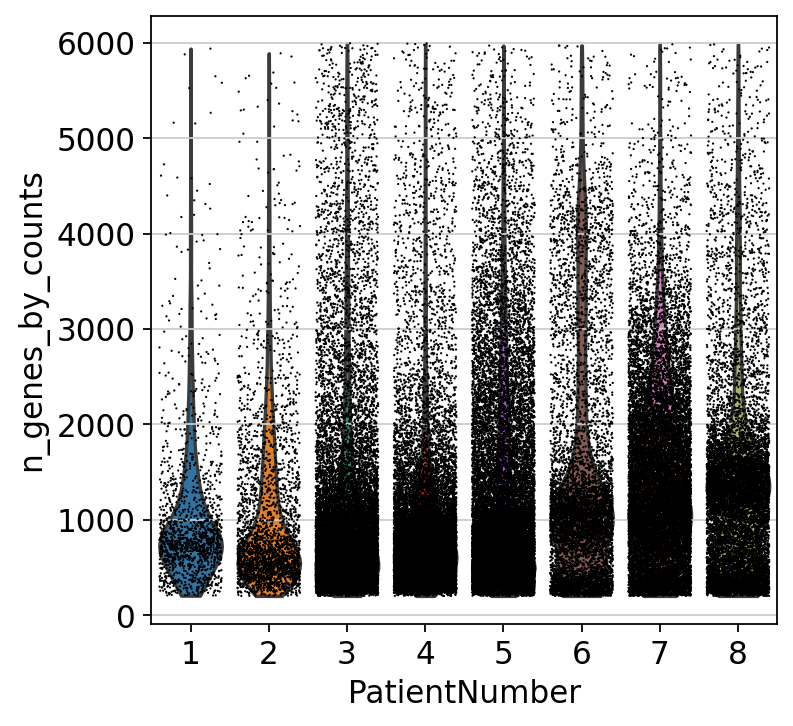

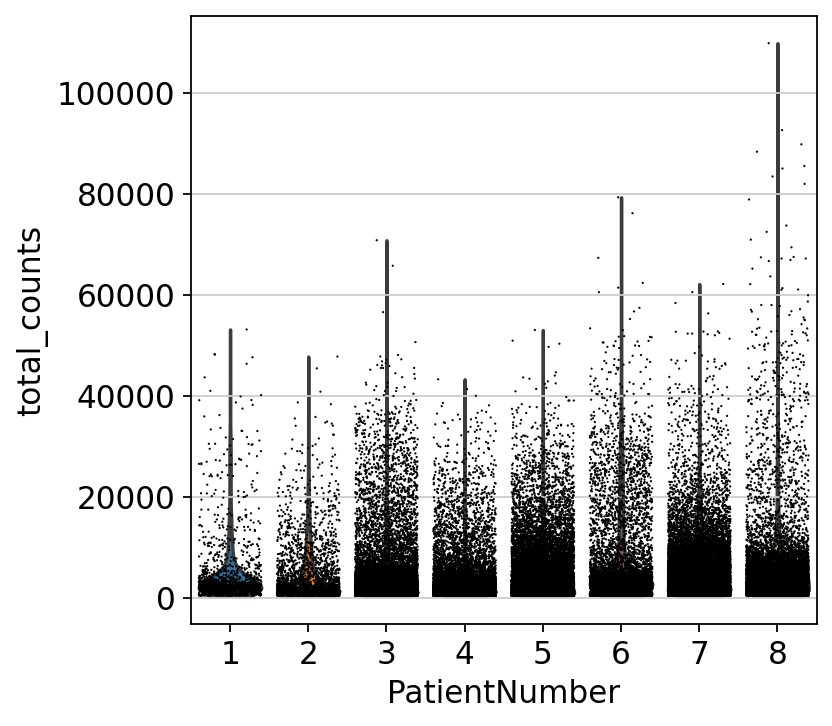

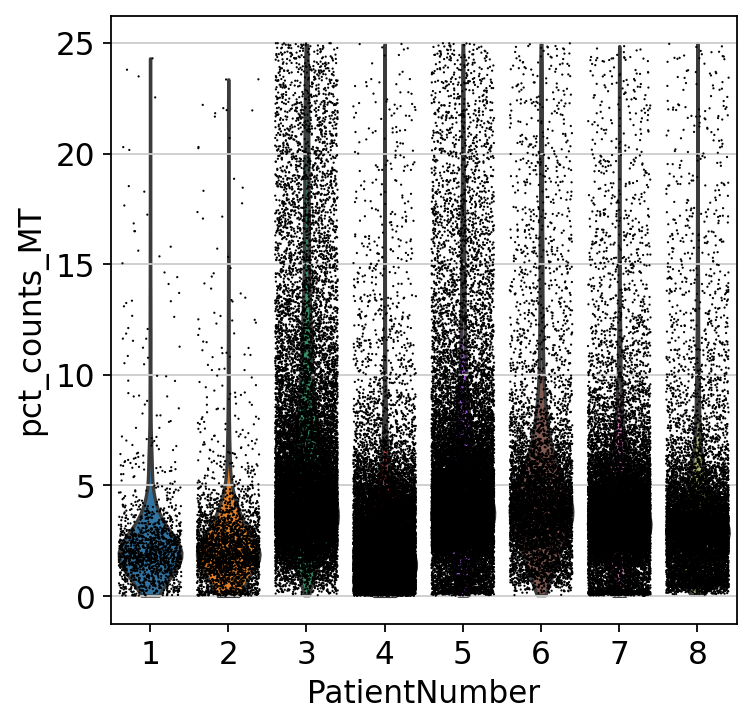

In [10]:
sc.pl.violin(adata, 'n_genes_by_counts',jitter=0.4, groupby="PatientNumber")
sc.pl.violin(adata, 'total_counts',jitter=0.4, groupby="PatientNumber")
sc.pl.violin(adata, 'pct_counts_MT',jitter=0.4, groupby="PatientNumber")


We store the raw expression counts in the `.layer["counts"]`

In [11]:
adata.layers["counts"] = adata.X.copy()

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

In [12]:
%%time
adata = adata[adata.obs.n_genes_by_counts < 5000, :]
adata = adata[adata.obs.pct_counts_MT < 20, :]

CPU times: user 14 ms, sys: 7.32 ms, total: 21.4 ms
Wall time: 20.7 ms


Some genes will now have zero expression in all cells. We filter out such genes.

In [13]:
%%time
sc.pp.filter_genes(adata, min_cells=3)

Trying to set attribute `.var` of view, copying.


CPU times: user 1.26 s, sys: 569 ms, total: 1.83 s
Wall time: 1.83 s


In [14]:
adata.shape

(91180, 25365)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [15]:
%%time
sc.pp.normalize_total(adata,target_sum=1e4)

CPU times: user 271 ms, sys: 21 ms, total: 292 ms
Wall time: 291 ms


Next, we log transform the count matrix.

In [16]:
%%time
sc.pp.log1p(adata)

CPU times: user 1.03 s, sys: 1.16 ms, total: 1.03 s
Wall time: 1.03 s


### Select Most Variable Genes

We will now select the most variable genes in the dataset.

In [17]:
%%time
sc.pp.highly_variable_genes(adata,flavor = "seurat_v3",n_top_genes=5000,batch_key="PatientNumber",layer = "counts")

CPU times: user 3.78 s, sys: 3.8 s, total: 7.58 s
Wall time: 3.24 s


Set the `.raw` attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use

In [18]:
%%time
adata.raw = adata

CPU times: user 44.4 ms, sys: 48.9 ms, total: 93.3 ms
Wall time: 92.3 ms


Restrict adata to only the highly variable genes

In [19]:
%%time
adata = adata[:, adata.var.highly_variable]

CPU times: user 44.6 ms, sys: 57.1 ms, total: 102 ms
Wall time: 101 ms


In [20]:
adata.shape

(91180, 5000)

Next we regess out effects of counts per cell and the mitochondrial content of the cells. 

In [21]:
%%time
sc.pp.regress_out(adata,keys=["total_counts", "pct_counts_MT"])

CPU times: user 9.05 s, sys: 10 s, total: 19.1 s
Wall time: 20.2 s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations, obtaining the preprocessed count matrix.

In [22]:
%%time
sc.pp.scale(adata, max_value=10)

CPU times: user 1.58 s, sys: 108 ms, total: 1.68 s
Wall time: 1.68 s


We store the preprocessed count matrix as an AnnData object, which is currently in host memory. We also add the expression levels of the marker genes as observations to the annData object.

In [23]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 32.82276964187622


## Clustering and Visulization

### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. 

In [24]:
%%time
sc.tl.pca(adata, n_comps = 100)

CPU times: user 1h 2min 29s, sys: 9min 23s, total: 1h 11min 53s
Wall time: 38 s


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

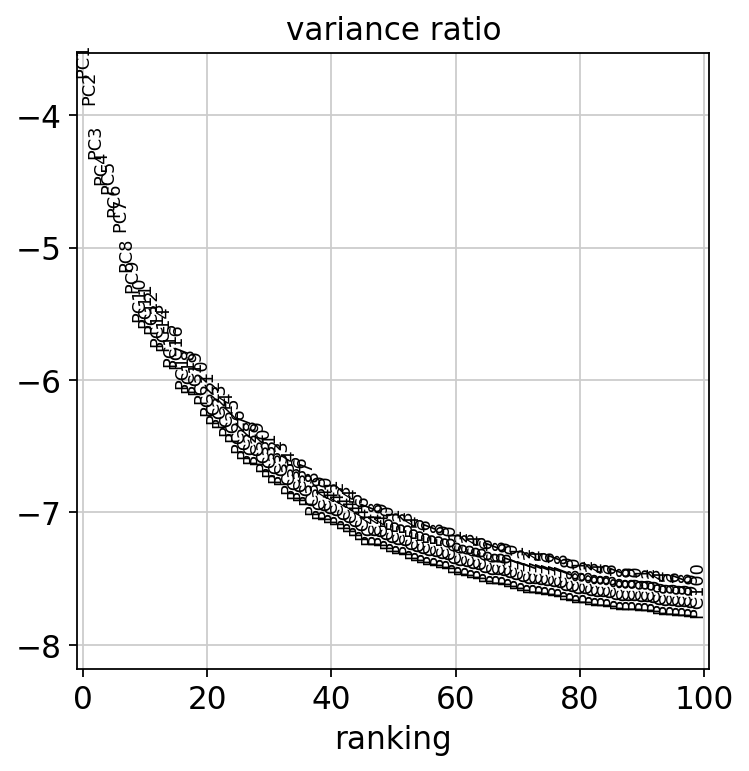

In [25]:
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=100)

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph and UMAP

In [26]:
%%time
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)

CPU times: user 1min 24s, sys: 4min 43s, total: 6min 8s
Wall time: 23.3 s


In [27]:
%%time
sc.tl.umap(adata)

CPU times: user 4min 4s, sys: 7min 35s, total: 11min 40s
Wall time: 36.3 s


### Clustering
We cluster the cells with the Leiden and Louvain algorithm

In [28]:
%%time
sc.tl.louvain(adata)

CPU times: user 34.6 s, sys: 222 ms, total: 34.8 s
Wall time: 34.6 s


In [29]:
%%time
sc.tl.leiden(adata)

CPU times: user 13.9 s, sys: 200 ms, total: 14.1 s
Wall time: 14 s


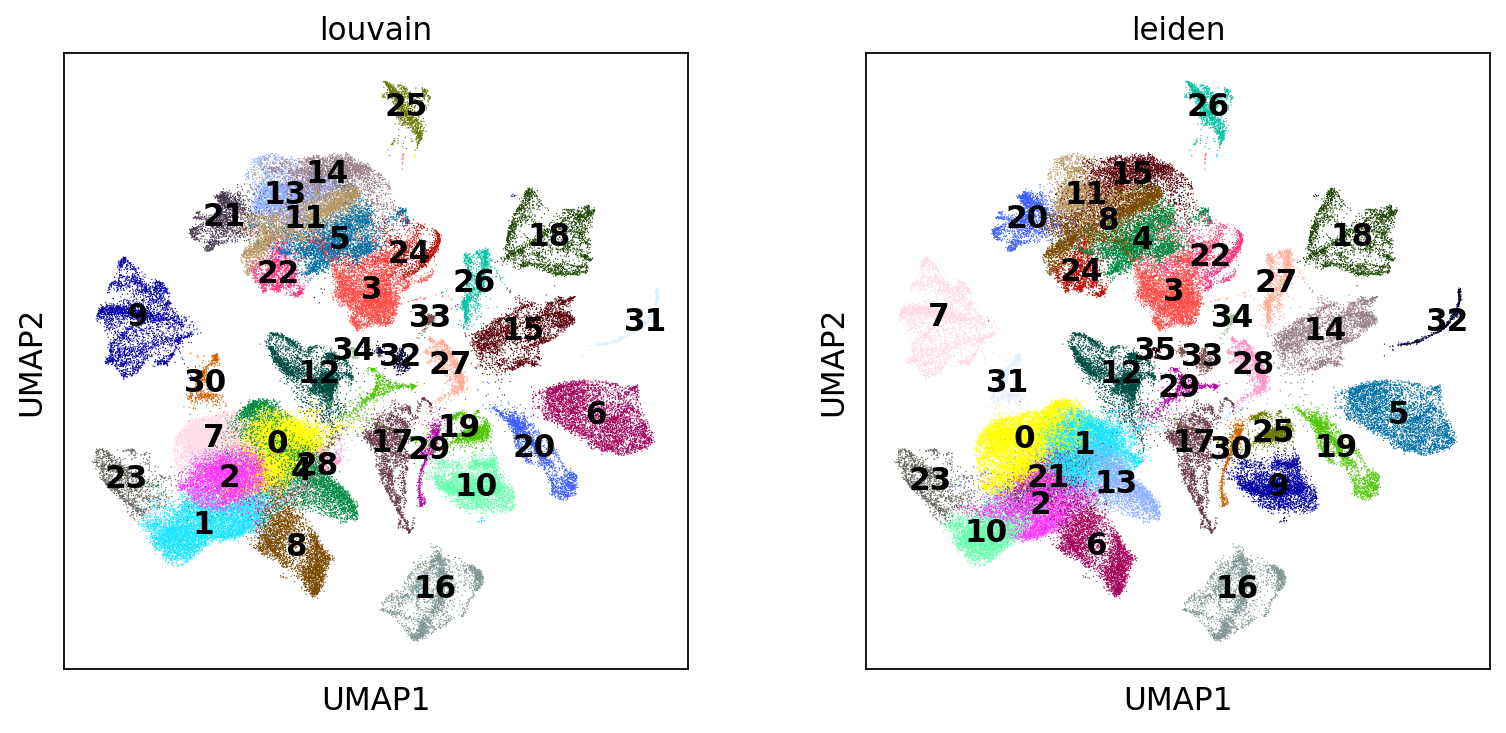

CPU times: user 779 ms, sys: 187 ms, total: 965 ms
Wall time: 772 ms


In [30]:
%%time
sc.pl.umap(adata, color=["louvain","leiden"],legend_loc = 'on data')

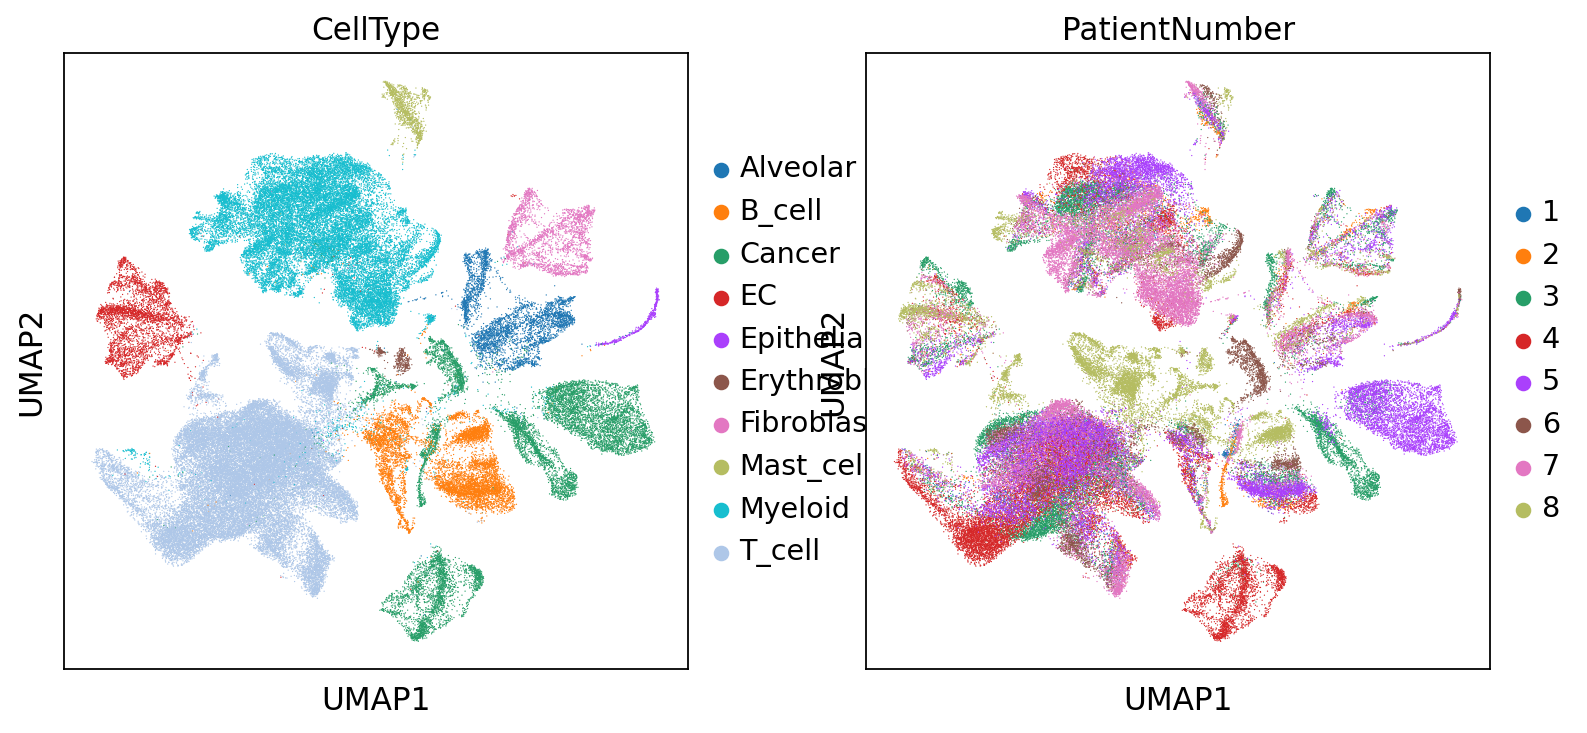

In [31]:
sc.pl.umap(adata, color= ["CellType", "PatientNumber"])

In [32]:
%%time
sc.tl.embedding_density(adata, groupby="PatientNumber")

CPU times: user 10.9 s, sys: 20.9 ms, total: 10.9 s
Wall time: 10.9 s


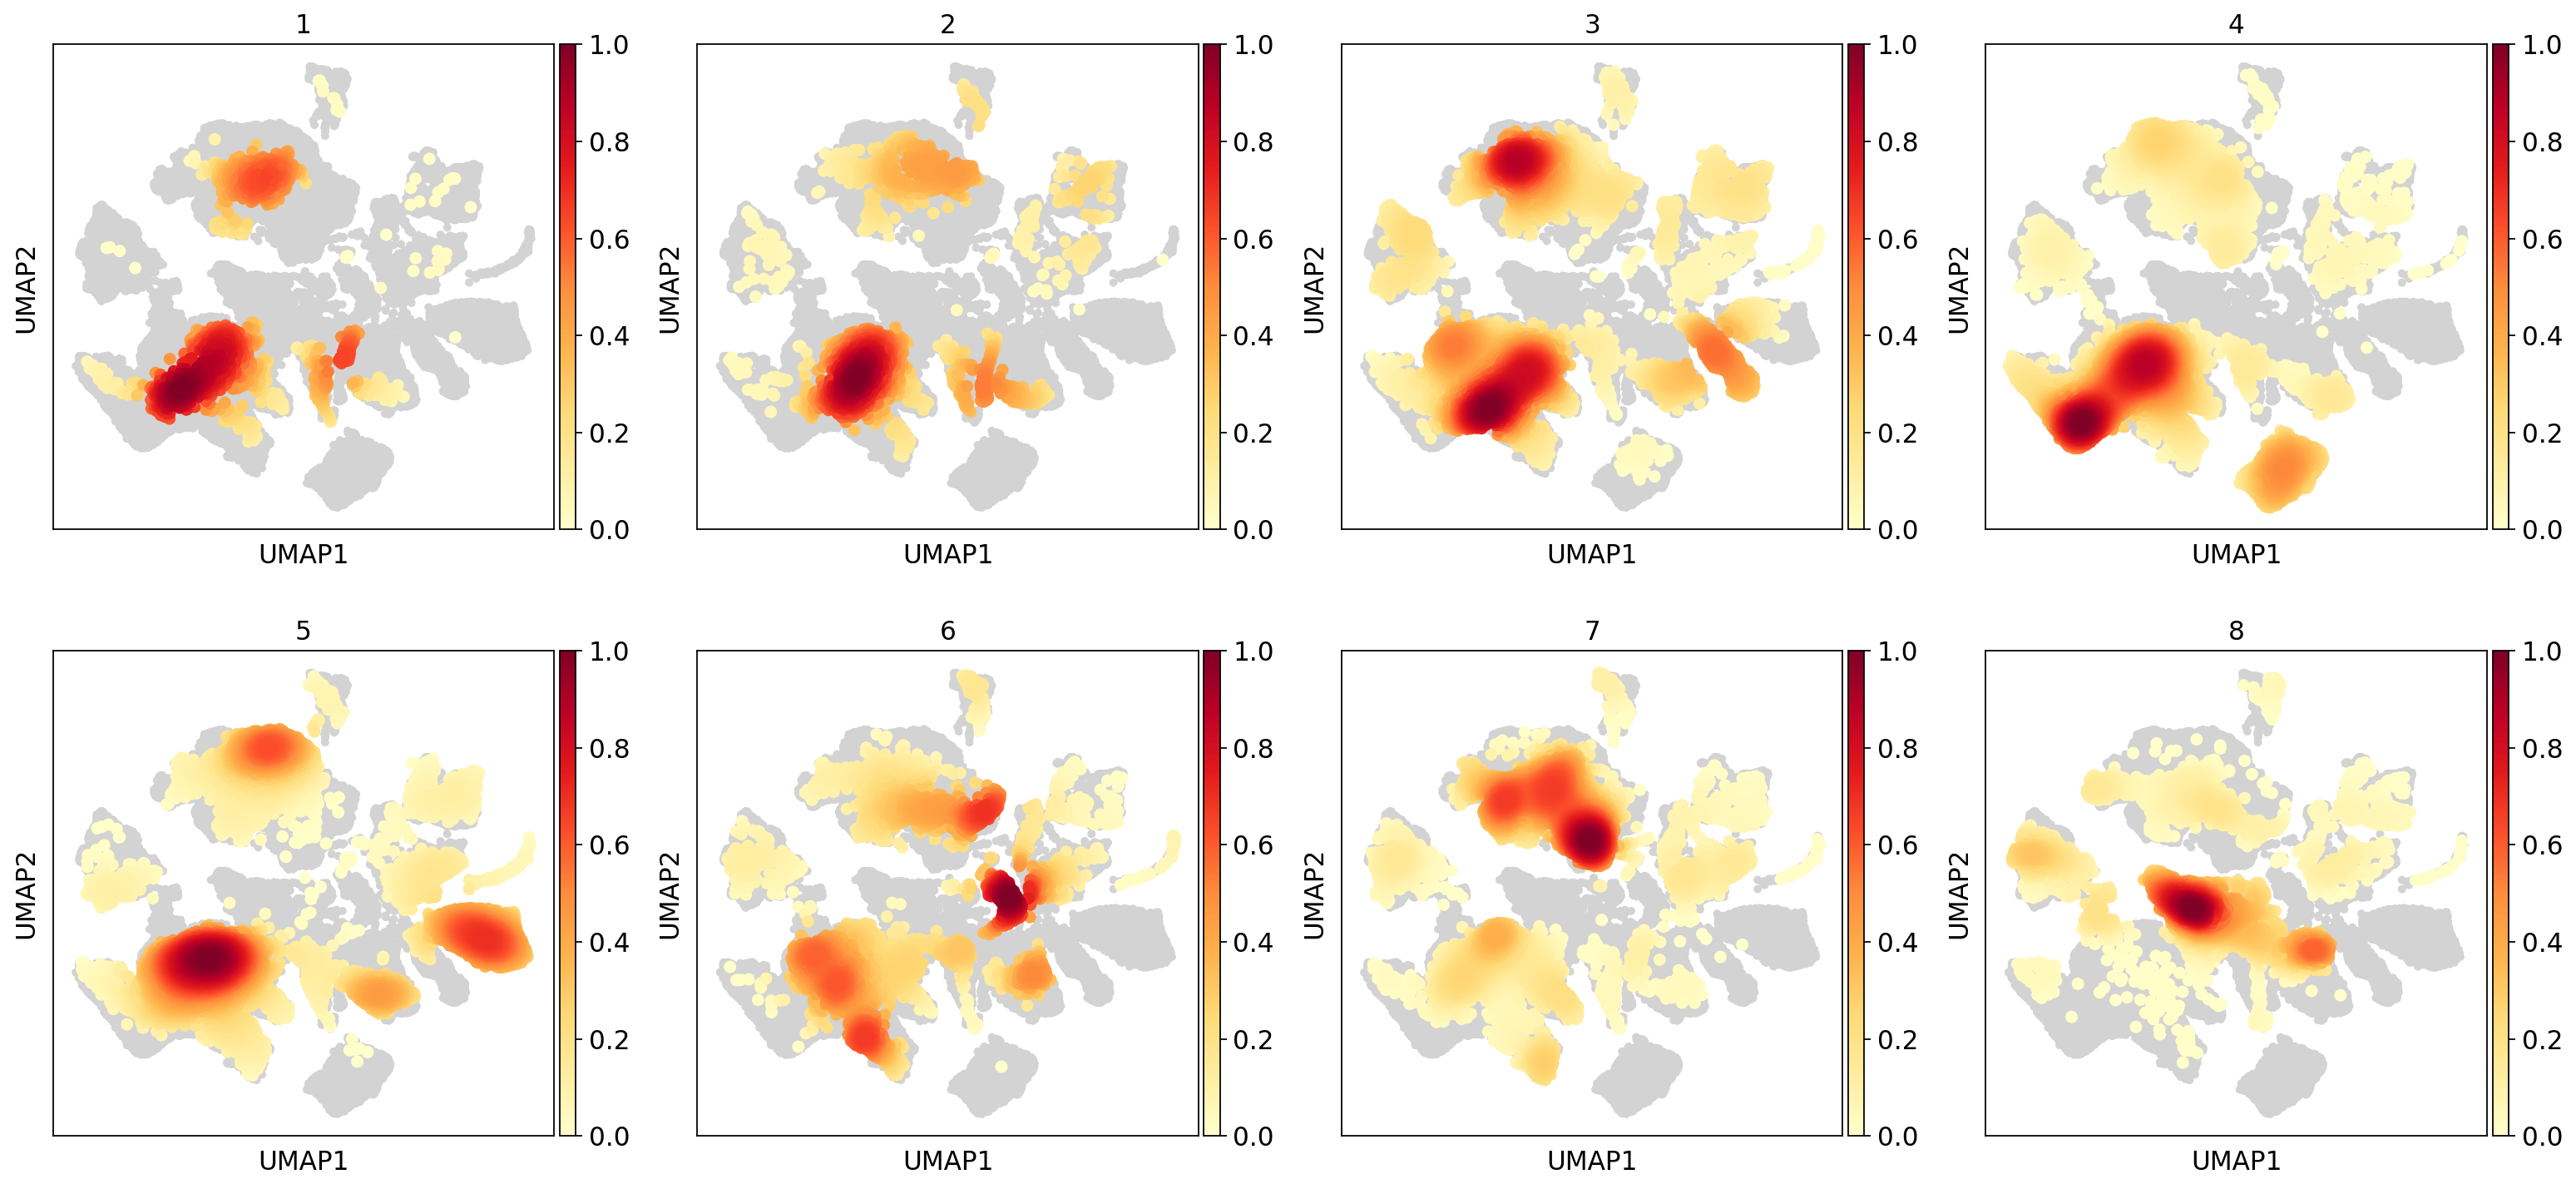

In [33]:
sc.pl.embedding_density(adata, groupby="PatientNumber")

### TSNE + K-means
You might want to skip this step. Calucating a TSNE for 90000 cells takes really long 

In [34]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8, random_state=0).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

In [35]:
%%time
sc.tl.tsne(adata, n_pcs = 40)

/home/sdicks-local/conda/rapids-22.04/lib/python3.9/site-packages/scanpy/tools/_tsne.py:113: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  warnings.warn(
/home/sdicks-local/conda/rapids-22.04/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


CPU times: user 2h 29min 14s, sys: 2h 35min 23s, total: 5h 4min 38s
Wall time: 6min 24s


/home/sdicks-local/conda/rapids-22.04/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'kmeans' as categorical


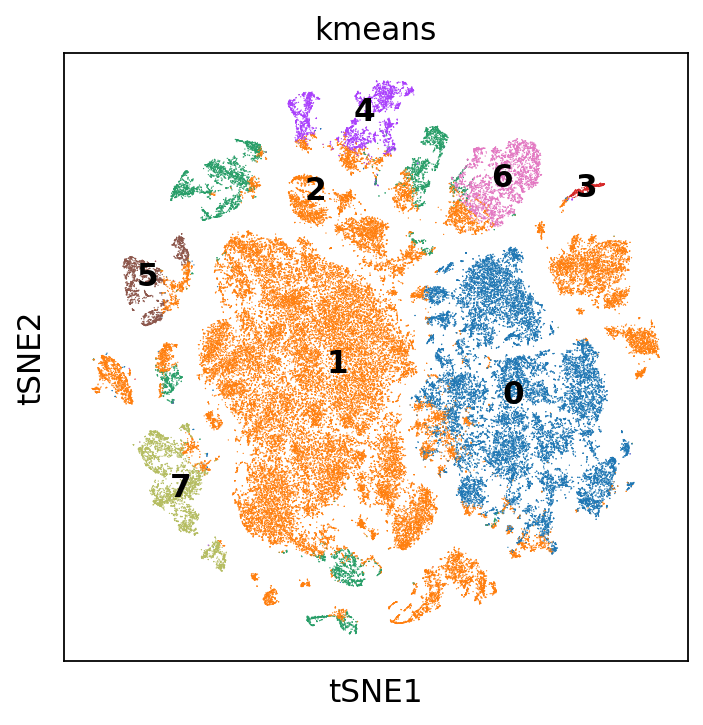

In [36]:
sc.pl.tsne(adata,color=["kmeans"], legend_loc='on data')

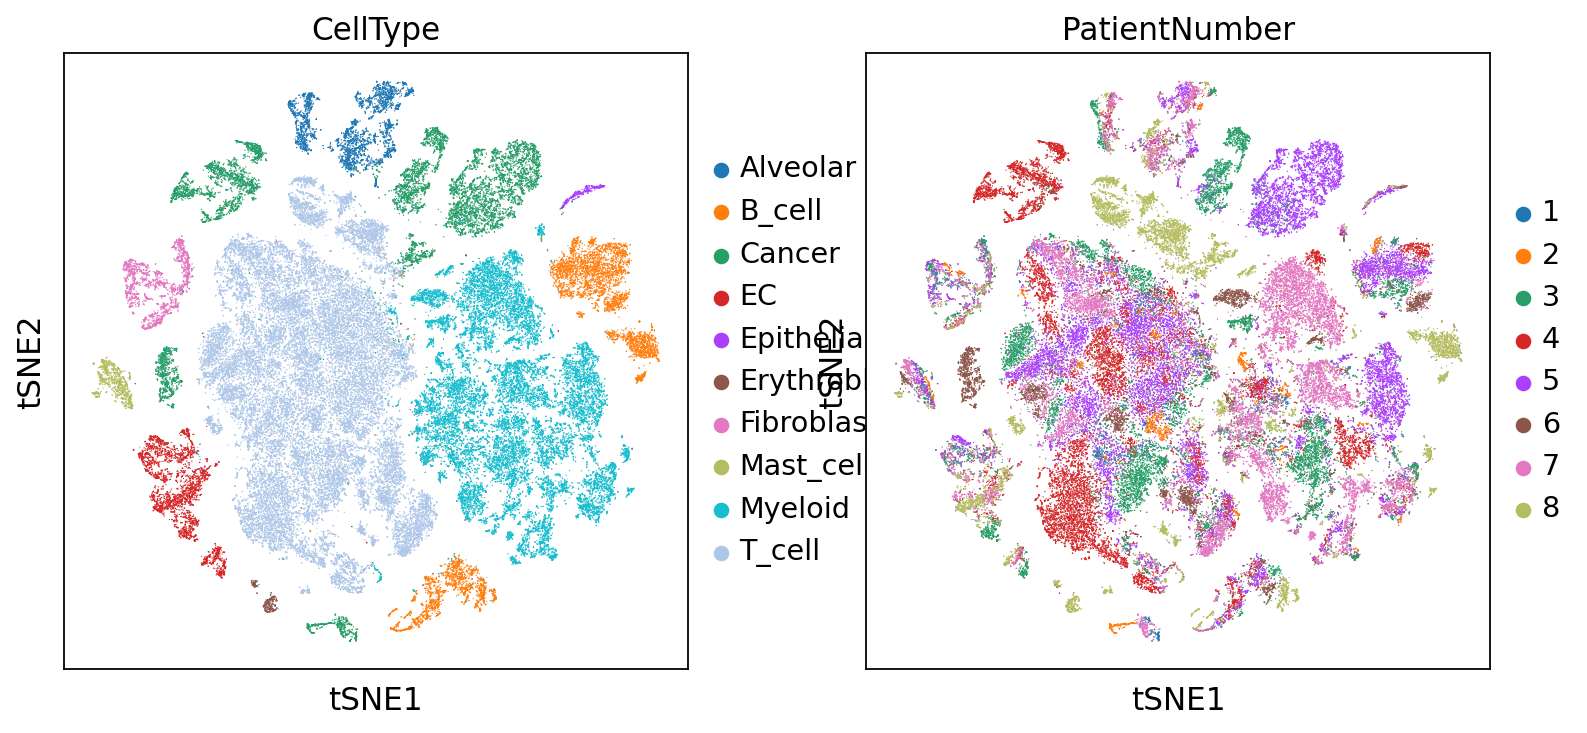

CPU times: user 965 ms, sys: 144 ms, total: 1.11 s
Wall time: 916 ms


In [37]:
%%time
sc.pl.tsne(adata, color= ["CellType", "PatientNumber"])

## Differential expression analysis

We now use logistic regression to compute a ranking for highly differential genes in each Louvain cluster.

In [38]:
%%time
sc.tl.rank_genes_groups(adata, 'CellType', method='logreg', use_raw=False)

CPU times: user 1h 4s, sys: 39min 51s, total: 1h 39min 55s
Wall time: 54.3 s


/home/sdicks-local/conda/rapids-22.04/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


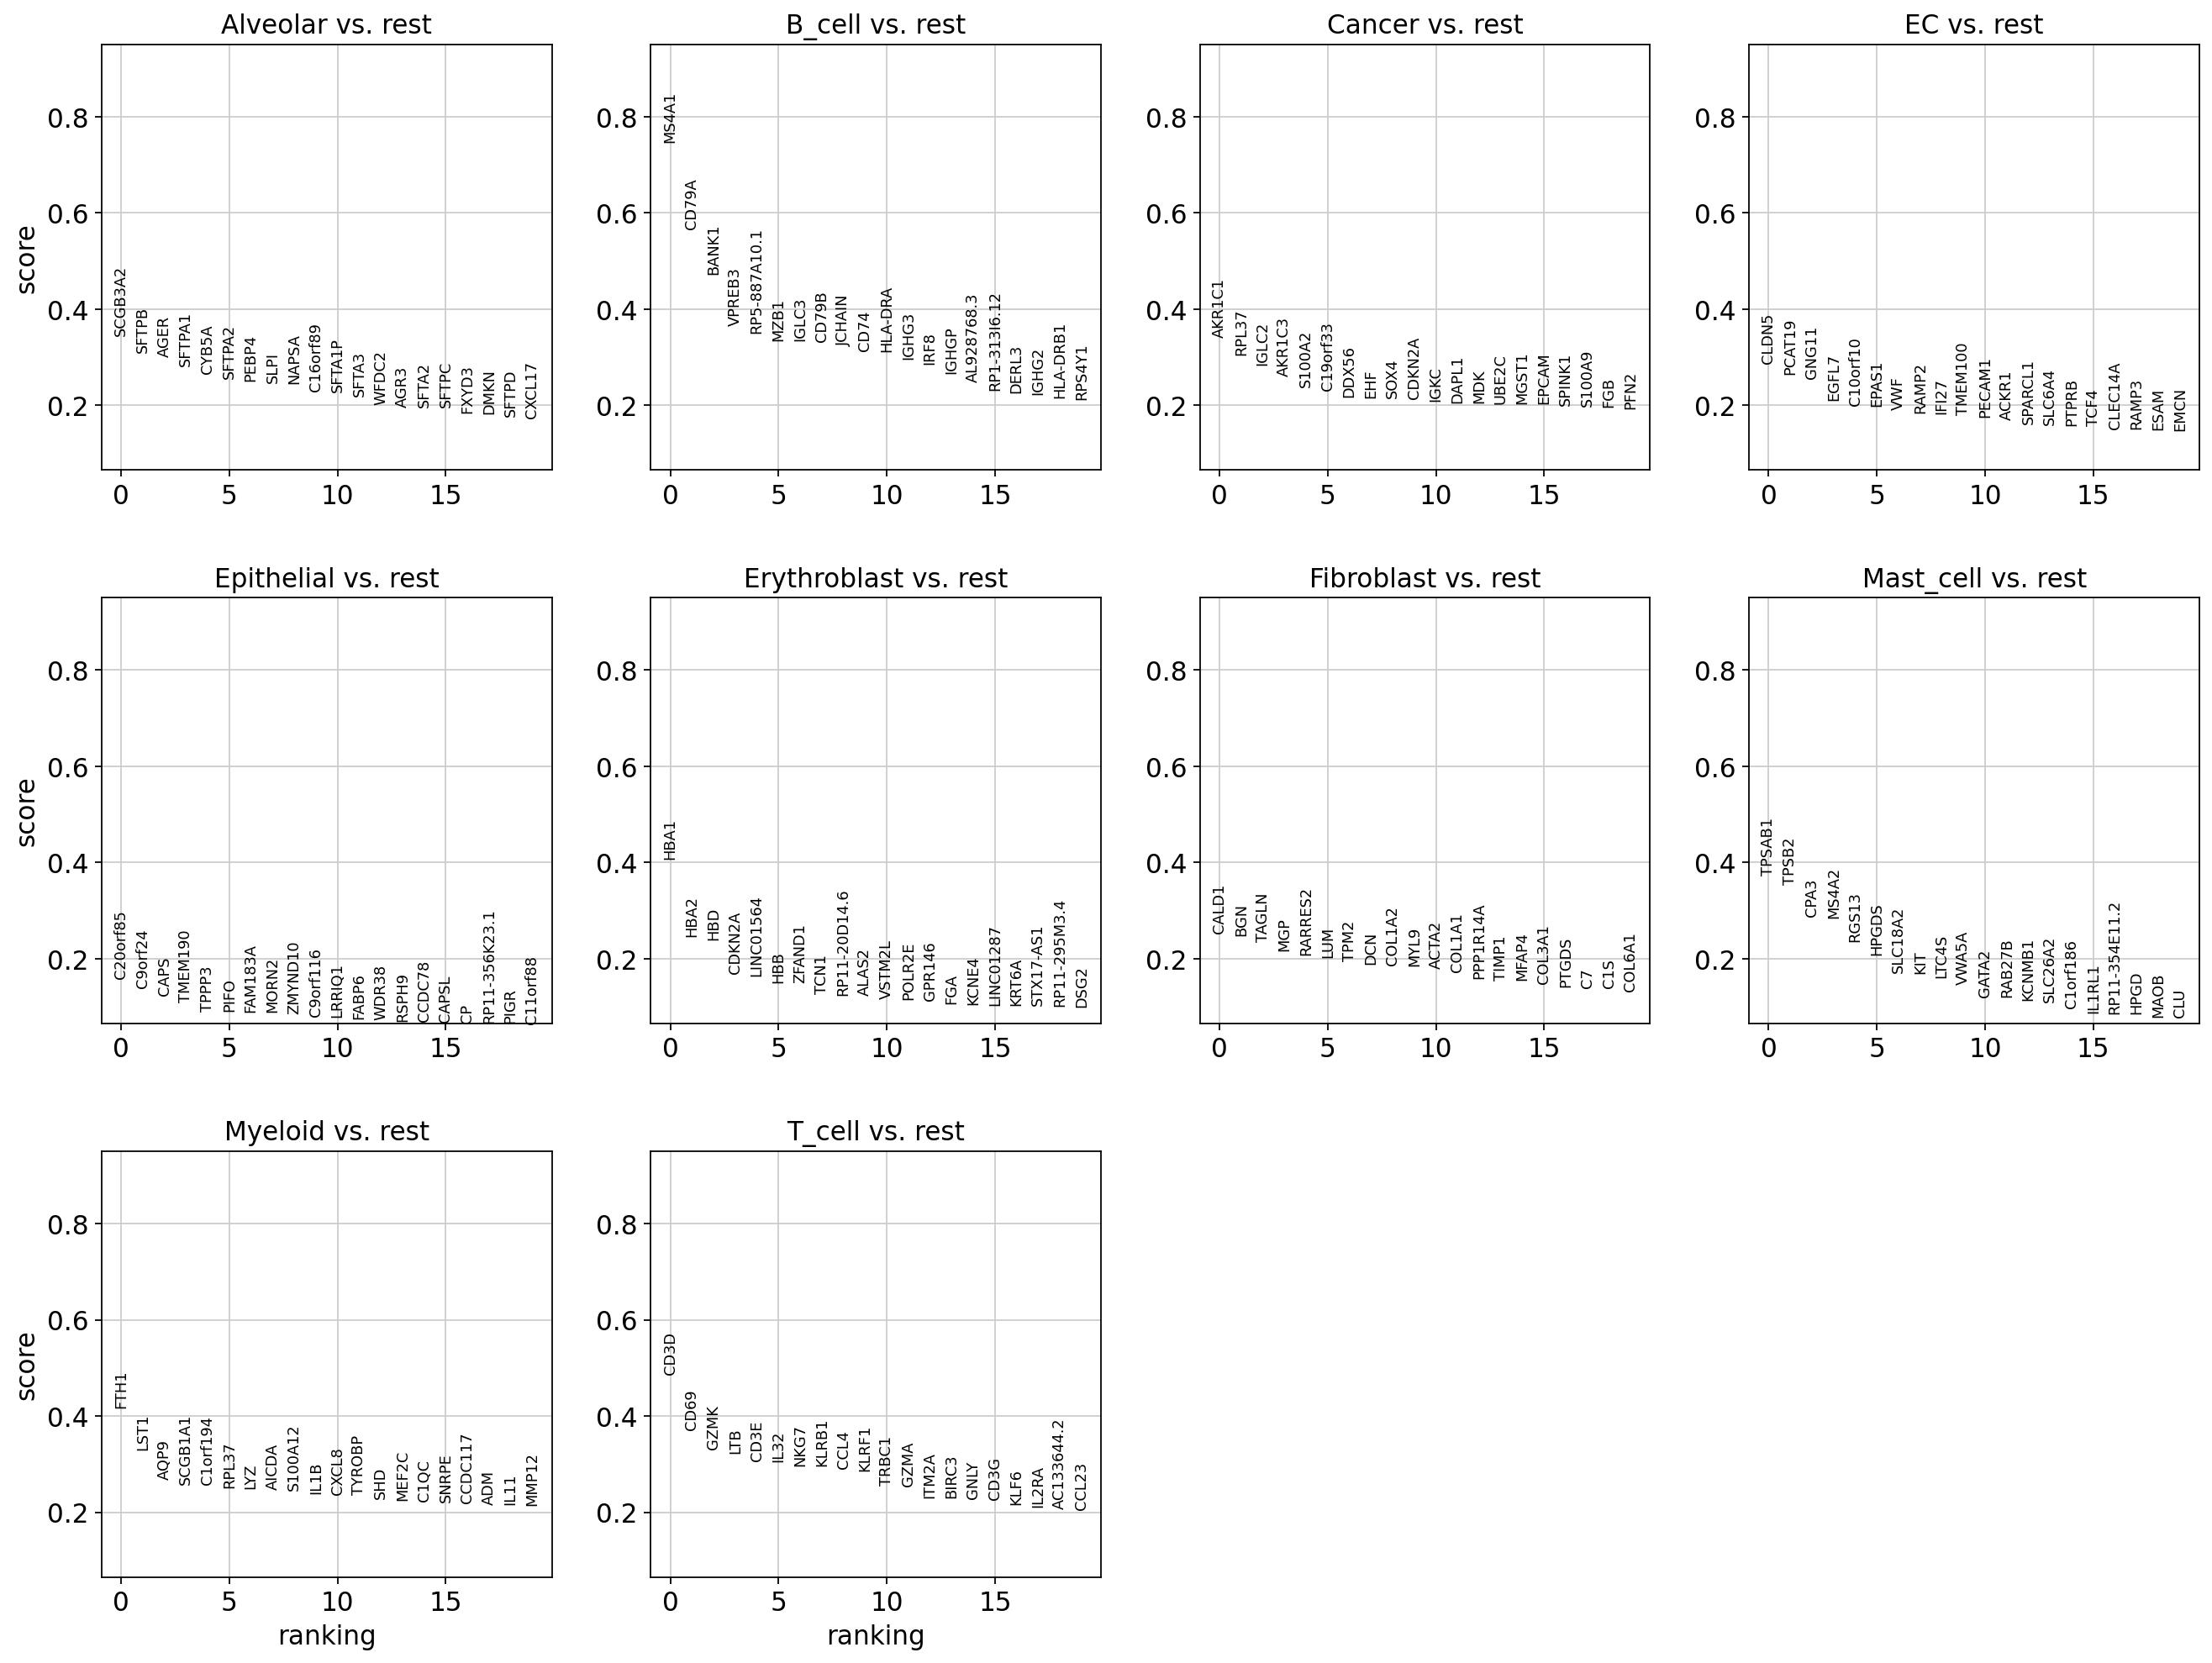

CPU times: user 1.46 s, sys: 2.01 s, total: 3.47 s
Wall time: 973 ms


In [39]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

In [40]:
post_time = time.time()

In [41]:
print("Total Postprocessing time: %s" % (post_time-preprocess_time))

Total Postprocessing time: 618.4391388893127


## Diffusion Maps

We now create a Diffusion Map of the T-Cells to look at trajectories.

First we create a subset of only the T-Cells

In [42]:
tdata = adata[adata.obs["CellType"] == 'T_cell',:]

We can repeat the dimension reduction, clustering and visulatization.

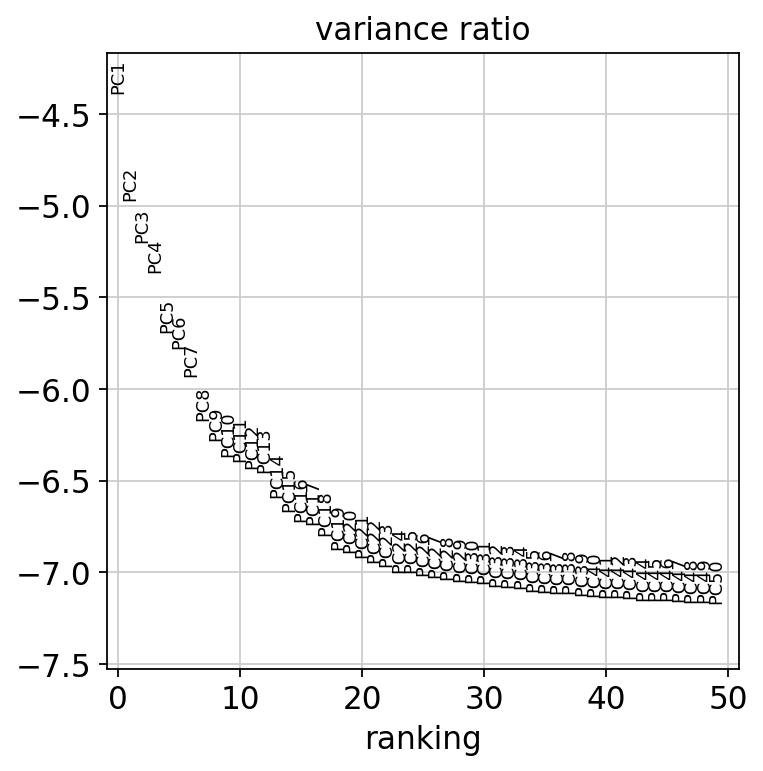

CPU times: user 29min 16s, sys: 4min 57s, total: 34min 14s
Wall time: 19.6 s


In [43]:
%%time
sc.pp.pca(tdata,n_comps=50)
sc.pl.pca_variance_ratio(tdata, log=True,n_pcs=50)

In [44]:
%%time
sc.pp.neighbors(tdata, n_neighbors=15, n_pcs=20)
sc.tl.umap(tdata)
sc.tl.louvain(tdata)

CPU times: user 1min 7s, sys: 2min 57s, total: 4min 5s
Wall time: 21.4 s


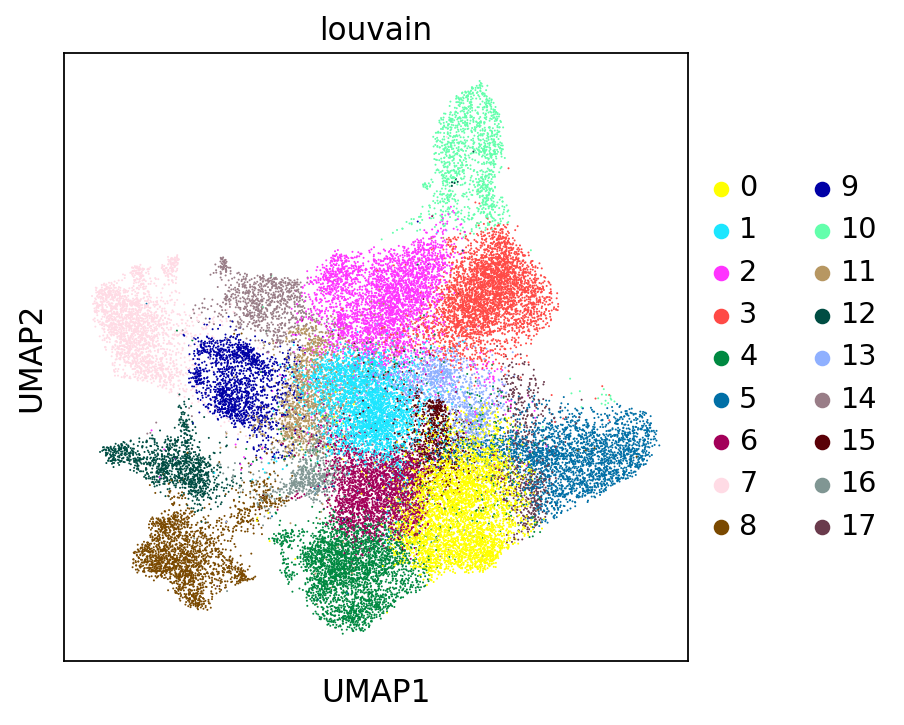

In [45]:
sc.pl.umap(tdata, color=["louvain"])

In [46]:
%%time
sc.tl.diffmap(tdata)

CPU times: user 46.2 s, sys: 2min 25s, total: 3min 11s
Wall time: 1.67 s


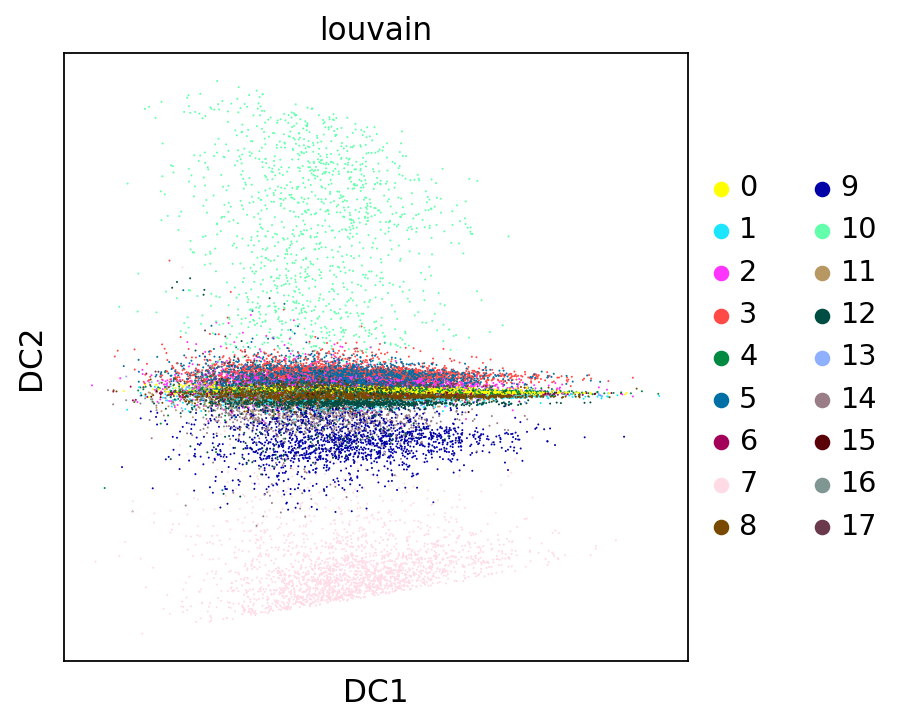

In [47]:
sc.pl.diffmap(tdata, color='louvain')

In [48]:
%%time
sc.tl.draw_graph(tdata)

CPU times: user 4min 19s, sys: 217 ms, total: 4min 20s
Wall time: 4min 20s


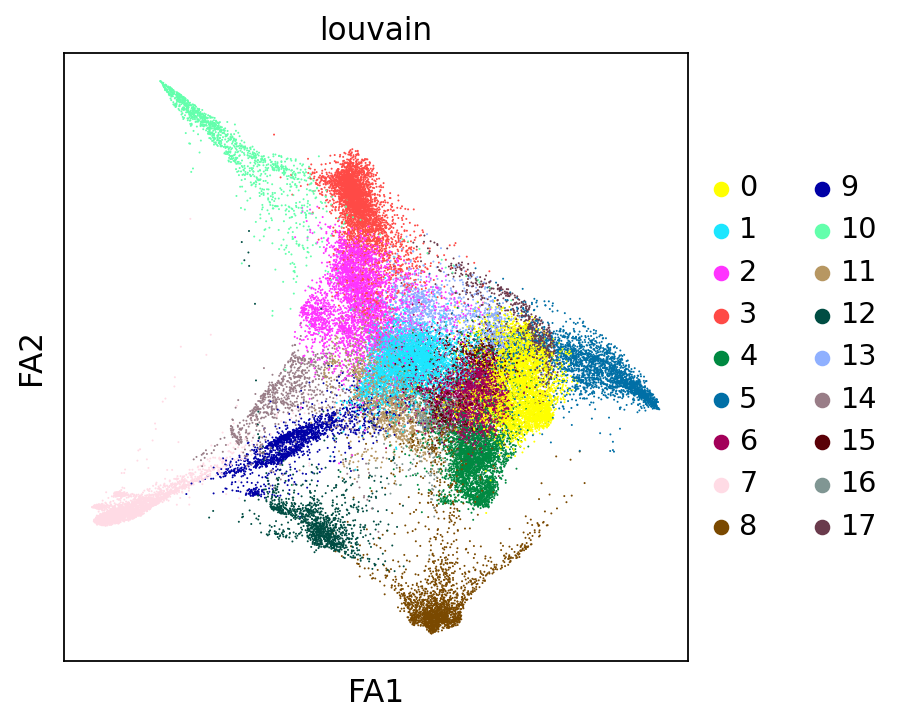

In [49]:
sc.pl.draw_graph(tdata, color='louvain')

In [50]:
print("Total Preprocessing time: %s" % (time.time()-preprocess_start))

Total Preprocessing time: 955.3477694988251
